In [1]:
import findspark as fs

import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import pandas as pd

print(sys.executable)
print(sys.path)
print(sys.version)

import photutils
from photutils import detect_threshold
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian2D

#from pyspark.sql.types import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import time

import shutil
from math import pi, log, sqrt
from tqdm import tqdm
import fnmatch
import random
import warnings
warnings.filterwarnings("ignore")

/home/s2494876/miniconda3/envs/sddm/bin/python
['/home/s2494876/miniconda3/envs/sddm/lib/python36.zip', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/lib-dynload', '', '/home/s2494876/.local/lib/python3.6/site-packages', '/home/s2494876/miniconda3/envs/sddm/lib/python3.6/site-packages', '/home/s2494876/.local/lib/python3.6/site-packages/IPython/extensions', '/home/s2494876/.ipython']
3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]


In [2]:
try:
    sc = SparkContext(appName="SDDM")
    #, master='spark://fs.dslc.liacs.nl:7078')
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
    print('warn')
    
print(sc._conf.get('spark.driver.memory'))

None


In [3]:
# Define data paths
DR2_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2/"
mosaic_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/"
writeable = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/"

# Calculate radius mosaic

In [4]:
def mosaic(file):
    hdul = fits.open(file)
    # data = hdul[0].data # The intensity data
    conv = hdul[0]._header["BMAJ"] # Should be 1/4 * BMAJ
    
    x = hdul[0]._header['NAXIS1']
    y = hdul[0]._header['NAXIS2']
    center = (x/2, y/2)

    # finite_area = np.sum(np.isfinite(data))
    # radius = np.sqrt(finite_area/pi) * conv
    radius = (max(x, y) / 2) * conv * (3/8)
    
    w = WCS(hdul[0].header)
    ra, dec = w.all_pix2world(x/2, y/2, 0, ra_dec_order=True)
    
    return np.array((radius, ra, dec))

In [5]:
fits_files = [mosaic_path + f for f in os.listdir(mosaic_path)]
random.shuffle(fits_files)
file_paths = sc.parallelize(fits_files, 64) # , len(fits_files)
file_paths.collect()

['/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P232+58_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P164+55_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P191+42_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P227+58_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P11Hetdex12_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P195+42_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P022+36_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P233+48_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P036+31_mosaic-blanked.fits',
 '/data/astronomy-big-data/bc96e9

In [6]:
test = file_paths.map(lambda fits: (mosaic(fits)))
info = np.array(test.collect())

# Map mosaics

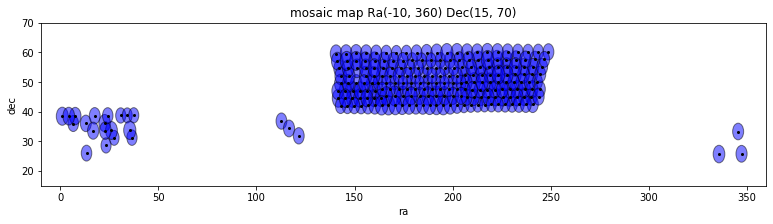

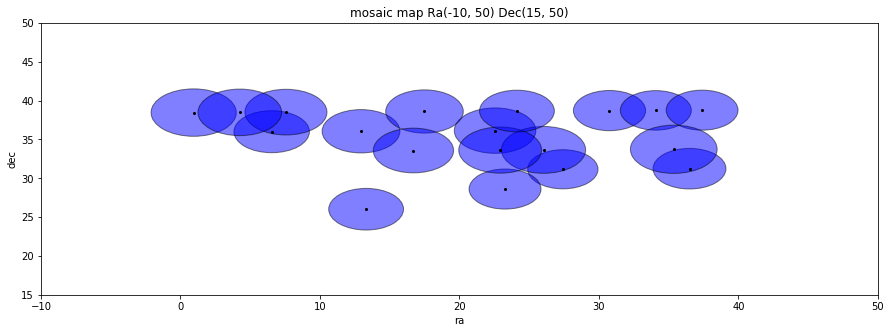

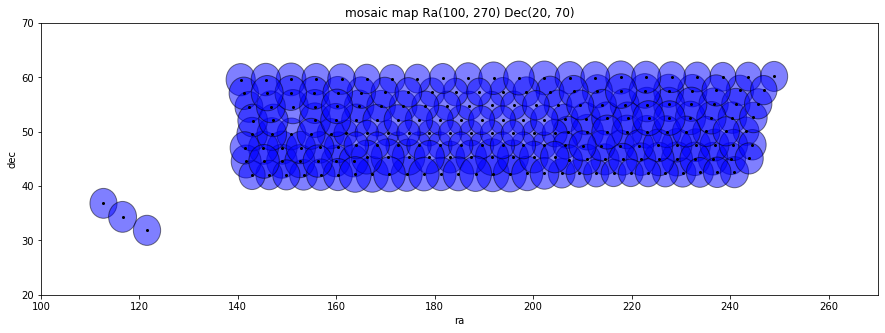

In [7]:
def map_mosaic(info, size=(15, 2), Ra=(-10, 360), Dec=(15, 70)):
    minRa, maxRa = Ra
    minDec, maxDec = Dec
    
    fig, ax = plt.subplots(figsize=size)
    for inf in info:
        ra = inf[1]
        dec = inf[2]
        if (ra >= minRa and ra <= maxRa) and (dec >= minDec and dec <= maxDec):
            ax.add_artist(plt.Circle((ra, dec), inf[0], edgecolor='black', alpha=0.5, facecolor='blue'))
            ax.plot(ra, dec, 'o', markersize=2, color='black')

    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.title('mosaic map Ra({}, {}) Dec({}, {})'.format(minRa, maxRa, minDec, maxDec))
    plt.xlim(minRa, maxRa)
    plt.ylim(minDec, maxDec)


map_mosaic(info, (13, 3))
map_mosaic(info, (15, 5), (-10, 50), (15, 50))
map_mosaic(info, (15, 5), (100, 270), (20, 70))

# Find overlapping mosaics

In [37]:
overlap_dict = {k.split('/')[-1].split('_')[0]: [] for k in fits_files}

for i, f1 in enumerate(fits_files):
    f1 = f1.split('/')[-1].split('_')[0]
    for j, f2 in enumerate(fits_files):
        if j > i:
            f2 = f2.split('/')[-1].split('_')[0]
            offset = np.array((info[i][1] - info[j][1], info[i][2] - info[j][2]))
            distance = np.sqrt(np.sum(np.power(offset, 2)))
            radius = (info[i][0] + info[j][0]) # * (8/3) * (1/4)
            if distance <= radius:
                overlap_dict[f1].append(f2)
                overlap_dict[f2].append(f1)

In [38]:
for k, v in overlap_dict.items():
    print(k, len(v))

P232+58 8
P164+55 9
P191+42 7
P227+58 8
P11Hetdex12 9
P195+42 6
P022+36 4
P233+48 10
P036+31 1
P20Hetdex17 8
P206+52 9
P174+42 6
P26Hetdex03 7
P159+45 9
P217+60 6
P13Hetdex12 8
P240+45 8
P32Hetdex08 8
P229+45 10
P030+39 1
P193+57 7
P167+42 6
P236+55 10
P38Hetdex07 7
P37Hetdex15 8
P191+55 7
P205+42 5
P214+45 8
P211+50 11
P158+50 9
P230+42 6
P229+48 11
P149+47 10
P223+50 10
P196+55 7
P18Hetdex03 8
P012+36 2
P241+58 7
P160+47 10
P198+42 5
P027+31 3
P140+60 4
P034+39 3
P238+60 5
P25Hetdex09 7
P142+55 7
P148+45 10
P236+45 9
P150+50 9
P209+42 5
P169+55 9
P217+47 10
P187+55 7
P19Hetdex17 8
P24Hetdex20 8
P233+60 5
P212+42 5
P186+60 5
P236+48 9
P184+57 6
P227+55 10
P232+45 10
P231+53 11
P347+26 0
P240+53 8
P153+42 6
P210+52 10
P206+50 12
P2Hetdex01 8
P156+47 9
P15Hetdex13 8
P023+29 2
P345+33 0
P037+39 2
P179+57 6
P226+42 7
P191+60 5
P013+26 0
P000+38 1
P141+57 5
P225+45 10
P10Hetdex 8
P223+55 10
P243+50 7
P026+34 4
P335+26 0
P145+47 11
P181+42 5
P150+60 6
P240+43 5
P146+42 7
P4Hetdex16 9
P39Het

In [10]:
overlaps = sc.parallelize(list(overlap_dict.items()), 32).flatMap(lambda x : map(lambda y: tuple(sorted((x[0], y))), x[1])).distinct()
overlaps.collect()

[('P223+55', 'P227+58'),
 ('P11Hetdex12', 'P9Hetdex01'),
 ('P233+48', 'P236+48'),
 ('P170+42', 'P174+42'),
 ('P227+50', 'P229+45'),
 ('P210+47', 'P214+45'),
 ('P156+45', 'P158+50'),
 ('P156+45', 'P160+47'),
 ('P023+29', 'P027+31'),
 ('P148+45', 'P153+42'),
 ('P182+55', 'P187+55'),
 ('P232+45', 'P236+48'),
 ('P239+50', 'P240+53'),
 ('P221+45', 'P226+42'),
 ('P141+57', 'P145+60'),
 ('P243+50', 'P244+48'),
 ('P145+57', 'P150+60'),
 ('P241+55', 'P245+55'),
 ('P141+45', 'P141+47'),
 ('P155+52', 'P155+57'),
 ('P14Hetdex04', 'P173+55'),
 ('P210+45', 'P213+47'),
 ('P198+57', 'P200+55'),
 ('P219+50', 'P219+52'),
 ('P219+50', 'P223+52'),
 ('P227+53', 'P232+55'),
 ('P12Hetdex11', 'P14Hetdex04'),
 ('P232+58', 'P236+55'),
 ('P227+55', 'P232+58'),
 ('P11Hetdex12', 'P13Hetdex12'),
 ('P188+42', 'P20Hetdex17'),
 ('P25Hetdex09', 'P26Hetdex03'),
 ('P24Hetdex20', 'P26Hetdex03'),
 ('P213+57', 'P217+60'),
 ('P229+45', 'P230+42'),
 ('P232+55', 'P236+55'),
 ('P35Hetdex10', 'P37Hetdex15'),
 ('P241+58', 'P245+5

# Prepare catalogue

In [11]:
header = ["label", "total_pixels", "x_pixels", "y_pixels",
          "integrated_intensity", "brightest_pixel", "brightest_pixel_x", "brightest_pixel_y",
          "brightest_pixel_RA", "brightest_pixel_DEC", "center_of_mass_x", "center_of_mass_y",
          "center_of_mass_RA", "center_of_mass_DEC", "center_of_gaus_fit_x", "center_of_gaus_fit_y",
          "center_of_gaus_fit_RA", "center_of_gaus_fit_DEC", "fit_x_axis", "fit_y_axis", "fit_theta",
          "deconv_x", "deconv_y", "integrated_intensity_fit", "ratio_residual"
         ]
catalogue = pd.read_csv(writeable + "catalogue_v5.csv", sep=",", names=header)

# Filter nans
rows = len(catalogue)
nan_rows = catalogue[catalogue.isnull().any(axis=1)]
ratio_nan = len(nan_rows) / rows
print('{0:.2f}% nan rows'.format(ratio_nan * 100))

# Show new catalogue
catalogue = catalogue[~catalogue.index.isin(nan_rows.index)].reindex()
catalogue['overlap'] = 0

# Add mosaic
catalogue['mosaic'], catalogue['object'] = catalogue['label'].str.split('_', 1).str
catalogue['object'] = catalogue['object'].astype(int)
catalogue.head()

0.15% nan rows


,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_x_axis,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,overlap,mosaic,object
0,P191+55_0,43,7,7,0.961113,0.001262,4195,13,191.526076,53.102602,...,1.719762,1.896624,-0.532125,0.632697,1.986707,0.971715,0.020838,0,P191+55,0
1,P191+55_1,20,7,5,0.326739,0.000757,4605,27,191.241494,53.108014,...,1.519698,1.080085,0.057949,0.000000,0.000000,0.330021,0.193748,0,P191+55,1
2,P191+55_2,45,8,7,0.745168,0.000793,3745,32,191.838427,53.110190,...,2.200380,1.810050,-0.030505,3.293620,1.472263,0.761026,0.051991,0,P191+55,2
3,P191+55_3,43,10,7,0.702810,0.000809,3775,33,191.817606,53.110655,...,1.720535,2.116901,0.055498,0.644249,2.974800,0.705155,0.082425,0,P191+55,3
4,P191+55_4,74,14,9,1.104583,0.000829,4346,35,191.421253,53.111697,...,3.113873,2.061817,-0.772092,6.145499,2.751915,1.080358,0.161090,0,P191+55,4


# Finding overlapping sources

In [12]:
key = overlaps.take(237)[-1][0]
value = overlaps.take(237)[-1][1]
print(key, value)
catalogue[(catalogue["mosaic"] == key) | (catalogue["mosaic"] == value)].sort_values(by=["brightest_pixel_RA", "brightest_pixel_DEC"]).head()

P202+42 P205+42


,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_x_axis,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,overlap,mosaic,object
1925033,P202+42_6208,44,7,7,0.861776,0.001093,9307,4893,199.671344,42.403532,...,1.953663,1.760587,0.187397,2.272624,1.090047,0.866931,0.024379,0,P202+42,6208
1925046,P202+42_6221,17,5,4,0.205727,0.000436,9303,4900,199.673480,42.406499,...,1.881318,1.207812,-0.160089,1.904302,0.000000,0.208779,0.065561,0,P202+42,6221
1925171,P202+42_6346,67,10,10,0.998376,0.000842,9299,4981,199.674326,42.440284,...,2.119623,2.450426,0.737493,2.985528,4.158907,1.013843,0.081550,0,P202+42,6346
1925058,P202+42_6233,235,28,19,3.032466,0.000662,9280,4911,199.686269,42.411374,...,2.938897,11.645355,2.176981,5.647508,27.129418,3.094192,0.215385,0,P202+42,6233
1925450,P202+42_6625,39,7,7,0.720604,0.000968,9270,5189,199.687090,42.527281,...,1.977636,1.548003,0.540477,2.384834,0.000000,0.732664,0.035634,0,P202+42,6625


In [13]:
mosaic_dict = {k: i for i, k in enumerate(overlap_dict.keys()) }
mosaic_dict_rev = {i: k for i, k in enumerate(overlap_dict.keys()) }
mosaic_dict

{'P232+58': 0,
 'P164+55': 1,
 'P191+42': 2,
 'P227+58': 3,
 'P11Hetdex12': 4,
 'P195+42': 5,
 'P022+36': 6,
 'P233+48': 7,
 'P036+31': 8,
 'P20Hetdex17': 9,
 'P206+52': 10,
 'P174+42': 11,
 'P26Hetdex03': 12,
 'P159+45': 13,
 'P217+60': 14,
 'P13Hetdex12': 15,
 'P240+45': 16,
 'P32Hetdex08': 17,
 'P229+45': 18,
 'P030+39': 19,
 'P193+57': 20,
 'P167+42': 21,
 'P236+55': 22,
 'P38Hetdex07': 23,
 'P37Hetdex15': 24,
 'P191+55': 25,
 'P205+42': 26,
 'P214+45': 27,
 'P211+50': 28,
 'P158+50': 29,
 'P230+42': 30,
 'P229+48': 31,
 'P149+47': 32,
 'P223+50': 33,
 'P196+55': 34,
 'P18Hetdex03': 35,
 'P012+36': 36,
 'P241+58': 37,
 'P160+47': 38,
 'P198+42': 39,
 'P027+31': 40,
 'P140+60': 41,
 'P034+39': 42,
 'P238+60': 43,
 'P25Hetdex09': 44,
 'P142+55': 45,
 'P148+45': 46,
 'P236+45': 47,
 'P150+50': 48,
 'P209+42': 49,
 'P169+55': 50,
 'P217+47': 51,
 'P187+55': 52,
 'P19Hetdex17': 53,
 'P24Hetdex20': 54,
 'P233+60': 55,
 'P212+42': 56,
 'P186+60': 57,
 'P236+48': 58,
 'P184+57': 59,
 'P227

In [14]:
catalogue["mosaic_id"] = catalogue["mosaic"].apply(lambda x: mosaic_dict[x])
catalogue.loc[:, ["mosaic", "mosaic_id"]]

,mosaic,mosaic_id
0,P191+55,25
1,P191+55,25
2,P191+55,25
3,P191+55,25
4,P191+55,25
...,...,...
2291390,P198+57,154
2291391,P198+57,154
2291392,P198+57,154
2291393,P198+57,154


In [15]:
def detectOverlap(data, labels): 
    # Define new df
    obj_rows = []
    
    # Define distance between brightest pixel
    eps = 0.0016
    i = 0
    # print('Finding overlaps between:', k, 'and', v)
    
    while i < len(data)-1:
        # Same mosaic
        # print(labels[i][0], labels[i+1][0])
        if labels[i][0] == labels[i+1][0]:
            # print('skip')
            i += 1
            continue
        
        if ((data[i + 1][0] >= data[i][0]-eps and data[i + 1][0] <= data[i][0]+eps) and 
            (data[i + 1][1] >= data[i][1]-eps and data[i + 1][1] <= data[i][1]+eps)):      
            
            # Add to new rows
            obj_rows.append(np.array(sorted([labels[i], labels[i+1]], key=lambda x: x[0])).astype(int))
            # obj_rows.append(np.array(sorted([labels[i], labels[i+1]])).astype(int))
            
            # Only 2 sources can overlap
            i += 2
        else:
            i += 1
    
    return np.array(obj_rows)

In [16]:
# k = overlaps.take(237)[-1][0]
# v = overlaps.take(237)[-1][1]

select = lambda s, k, v: np.array_split(np.array(
    s[(s["mosaic"] == k) | (s["mosaic"] == v)]
    .sort_values(by=["brightest_pixel_RA", "brightest_pixel_DEC"])
    .loc[:, ["brightest_pixel_RA", "brightest_pixel_DEC", "mosaic_id", "object"]]
), 2, axis=1)


# select(catalogue, overlaps.take(237)[-1][0], overlaps.take(237)[-1][1])


In [17]:
overlap_rows = overlaps.flatMap(lambda o: detectOverlap(np.around(select(catalogue, o[0], o[1])[0], 5), # o[0] + "_" + o[1],
                                          select(catalogue, o[0], o[1])[1].astype(int),
                                                       )
                               )

# Group overlapping sources

In [18]:
grouped_overlaps = overlap_rows.map(lambda x: (tuple(x[0]), x[1])).groupByKey().mapValues(list)

# Label overlapping sources

In [19]:
np_cat = catalogue.loc[:, ["mosaic_id", "object", "total_pixels"]].values
print(np_cat[:5])

[[25  0 43]
 [25  1 20]
 [25  2 45]
 [25  3 43]
 [25  4 74]]


In [20]:
np_cat[ np.where((np_cat[:, 0] == 36) & (np_cat[:, 1] == 4802)) ]

array([[  36, 4802,   21]])

In [21]:
# lookup = lambda d, arr: int(d[(d["mosaic_id"] == arr[0]) & (d["object"] == arr[1])]["total_pixels"].values)
lookup = lambda d, arr: d[np.where((np_cat[:, 0] == arr[0]) & (np_cat[:, 1] == arr[1] ))][0][-1]

def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item
            
            
def labelOverlap(combs, p_arg):
    overlap_arr = np.ones((len(combs), 3), dtype=int)
    overlap_arr[:, :2] = combs
    overlap_arr[p_arg, 2] += 1
    return overlap_arr

In [22]:
flattened_grouped_overlaps = grouped_overlaps.map(lambda g: tuple(zip(*[iter(tuple(flatten(g)))]*2)) )
# combinations = flattened_grouped_overlaps.collect()

In [23]:
source_pixels = flattened_grouped_overlaps.map(lambda combs: labelOverlap(combs,
                                                                          np.argmax([lookup(np_cat, c) for c in combs])
                                                                         )
                                              )
source_labels = source_pixels.collect()
source_labels[:5]

[array([[  88,  374,    2],
        [ 211, 9125,    1],
        [ 199, 9426,    1]]),
 array([[  96, 3006,    2],
        [ 217, 2029,    1]]),
 array([[   7, 5163,    2],
        [  58, 4175,    1]]),
 array([[   7, 5355,    2],
        [  58, 4331,    1]]),
 array([[ 138, 9856,    2],
        [ 171, 1246,    1],
        [ 227, 1282,    1]])]

In [69]:
flatten_source_labels = np.array([item for sublist in source_labels for item in sublist])
print(flatten_source_labels.shape)
flatten_source_labels[:5]

(821246, 3)


array([[  88,  374,    2],
       [ 211, 9125,    1],
       [ 199, 9426,    1],
       [  96, 3006,    2],
       [ 217, 2029,    1]])

In [91]:
flatten_source_labels[(flatten_source_labels[:,0] == 148) & (flatten_source_labels[:,1] == 7047)]

array([[ 148, 7047,    1],
       [ 148, 7047,    2]])

In [112]:
df_source_labels = pd.DataFrame(flatten_source_labels, columns=["mosaic_id", "object", "overlap"])
df_source_labels.head()

,mosaic_id,object,overlap
0,88,374,2
1,211,9125,1
2,199,9426,1
3,96,3006,2
4,217,2029,1


In [113]:
df_source_labels[(df_source_labels["mosaic_id"] == 148) & (df_source_labels["object"] == 7047)]

,mosaic_id,object,overlap
4765,148,7047,1
677006,148,7047,2


In [115]:
print(len(df_source_labels))

df_source_labels = df_source_labels.sort_values(['mosaic_id', 'object', 'overlap']).drop_duplicates(['mosaic_id', 'object'], keep='first')

print(len(df_source_labels))

df_source_labels[(df_source_labels["mosaic_id"] == 148) & (df_source_labels["object"] == 7047)]


821246
761723


,mosaic_id,object,overlap
4765,148,7047,1


In [116]:
# Remove duplicate pairs keep the lowest
df_source_labels.groupby(['mosaic_id', 'object'])['overlap'].min()

mosaic_id  object
0          2         1
           7         1
           8         2
           12        2
           14        1
                    ..
227        11776     2
           11777     2
           11780     2
           11782     2
           11791     2
Name: overlap, Length: 761723, dtype: int64

In [117]:
new_cat = pd.merge(catalogue, df_source_labels, how='left', on=['mosaic_id', 'object'])
new_cat.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,overlap_x,mosaic,object,mosaic_id,overlap_y
0,P191+55_0,43,7,7,0.961113,0.001262,4195,13,191.526076,53.102602,...,-0.532125,0.632697,1.986707,0.971715,0.020838,0,P191+55,0,25,1.0
1,P191+55_1,20,7,5,0.326739,0.000757,4605,27,191.241494,53.108014,...,0.057949,0.000000,0.000000,0.330021,0.193748,0,P191+55,1,25,NaN
2,P191+55_2,45,8,7,0.745168,0.000793,3745,32,191.838427,53.110190,...,-0.030505,3.293620,1.472263,0.761026,0.051991,0,P191+55,2,25,NaN
3,P191+55_3,43,10,7,0.702810,0.000809,3775,33,191.817606,53.110655,...,0.055498,0.644249,2.974800,0.705155,0.082425,0,P191+55,3,25,2.0
4,P191+55_4,74,14,9,1.104583,0.000829,4346,35,191.421253,53.111697,...,-0.772092,6.145499,2.751915,1.080358,0.161090,0,P191+55,4,25,NaN


In [118]:
new_cat['overlap'] = np.max(new_cat[['overlap_x', 'overlap_y']], axis=1).astype(int)
new_cat = new_cat.drop(labels=['overlap_x', 'overlap_y'], axis=1)
new_cat.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
0,P191+55_0,43,7,7,0.961113,0.001262,4195,13,191.526076,53.102602,...,1.896624,-0.532125,0.632697,1.986707,0.971715,0.020838,P191+55,0,25,1
1,P191+55_1,20,7,5,0.326739,0.000757,4605,27,191.241494,53.108014,...,1.080085,0.057949,0.000000,0.000000,0.330021,0.193748,P191+55,1,25,0
2,P191+55_2,45,8,7,0.745168,0.000793,3745,32,191.838427,53.110190,...,1.810050,-0.030505,3.293620,1.472263,0.761026,0.051991,P191+55,2,25,0
3,P191+55_3,43,10,7,0.702810,0.000809,3775,33,191.817606,53.110655,...,2.116901,0.055498,0.644249,2.974800,0.705155,0.082425,P191+55,3,25,2
4,P191+55_4,74,14,9,1.104583,0.000829,4346,35,191.421253,53.111697,...,2.061817,-0.772092,6.145499,2.751915,1.080358,0.161090,P191+55,4,25,0


In [119]:
new_cat[(new_cat["mosaic_id"] == 148) & (new_cat["object"] == 7047)]

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
2127736,P6_7047,44,7,8,0.511099,0.000384,3616,7389,166.304841,51.251456,...,3.535001,0.733176,3.436901,7.300262,0.518924,0.132137,P6,7047,148,1


In [120]:
len(new_cat[new_cat["overlap"] > 0])

761723

In [121]:
len(new_cat[new_cat["overlap"] == 1])

397503

In [122]:
len(new_cat[new_cat["overlap"] == 2])

364220

In [127]:
len(new_cat[(new_cat["overlap"] == 0) | (new_cat["overlap"] == 2)])

1890376

# Save overlapping sources

In [ ]:
out = "overlapping_sources"
if os.path.isdir(out):
    shutil.rmtree(out)

flattened_grouped_overlaps.map(lambda g: g).coalesce(1, shuffle = True).saveAsTextFile(out)

In [125]:
cat_out = os.path.join(writeable, 'catalogue_v5.3.csv')
new_cat.to_csv(cat_out, sep=',')

# Verify

In [32]:
IMAGE_PATH = '/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/' # './images_upper'
WRITE_PATH = './temp'


def crop(r, num_pxl):
    file = ''.join(fnmatch.filter(os.listdir(IMAGE_PATH), r['mosaic'].values[0] + '*.fits'))
    # print(file)
    hdul = fits.open(os.path.join(IMAGE_PATH, file))
    
    data = hdul[0].data
    threshold = detect_threshold(data, nsigma=3.)
    sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
    # Use kernel (3x3) to find borders of sources
    kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
    kernel.normalize()
    # sources = object with label of sources for each pixel in the fits file
    sources = detect_sources(data, threshold, npixels=16, filter_kernel=kernel)
    
    r_img = sources._data
    
    w, h = r_img.shape    
    x = int(r['brightest_pixel_x'].values[0])
    y = int(r['brightest_pixel_y'].values[0])
    
    left = int(x - num_pxl if x - num_pxl > 0 else x - 1)
    top = int(y - num_pxl if y - num_pxl > 0 else y - 1)
    right = int(x + num_pxl if x + num_pxl < w else w)
    bottom = int(y + num_pxl if y + num_pxl < h else h)
    
    r_crop = r_img[top:bottom, left:right]
    d_crop = data[top:bottom, left:right]
    cmap = sources.make_cmap(random_state=12345)
    return d_crop, r_crop, cmap


def getImgs(df, combs):
    fig, ax = plt.subplots(len(combs), 2, figsize=(15,10))
    
    row = df[(df["mosaic_id"] == combs[0][0]) & (df["object"] == combs[0][1])]
    num_pxl = max(row['x_pixels'].values, row['y_pixels'].values) + 15
    for i, c in enumerate(combs):
        row = df[(df["mosaic_id"] == c[0]) & (df["object"] == c[1])]
        d_crop, r_crop, cmap = crop(row, num_pxl)
        
        # Source
        ax[i,0].imshow(r_crop, cmap=cmap)
        ax[i,0].scatter(r_crop.shape[0]// 2, r_crop.shape[1] // 2, s=4, c='red')
        # ax[i,0].set_title("%s;#pxl:%s"%(row['label'].values, row['total_pixels'].values))
        
        # Data
        ax[i,1].imshow(d_crop, origin='upper')
        ax[i,1].scatter(d_crop.shape[0]// 2, d_crop.shape[1] // 2, s=4, c='red')
    
    plt.show()
    print('-'*50)

In [33]:
groups = grouped_overlaps.collect()

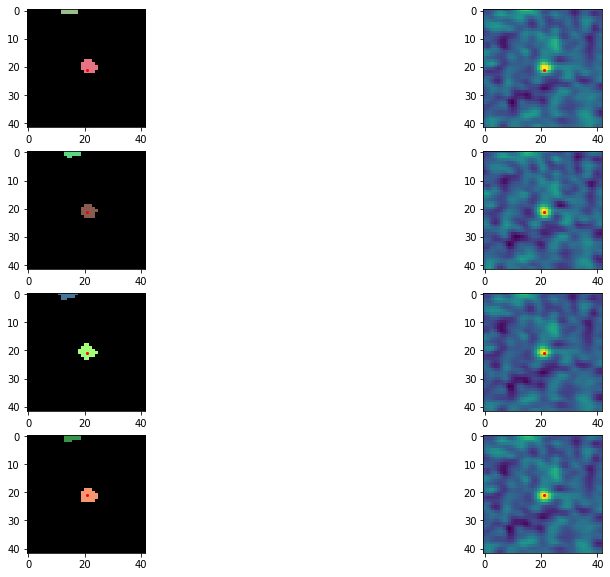

--------------------------------------------------


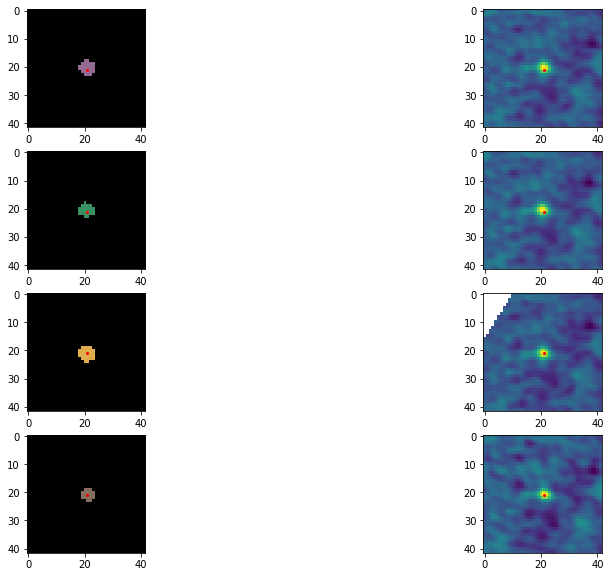

--------------------------------------------------


KeyboardInterrupt: 

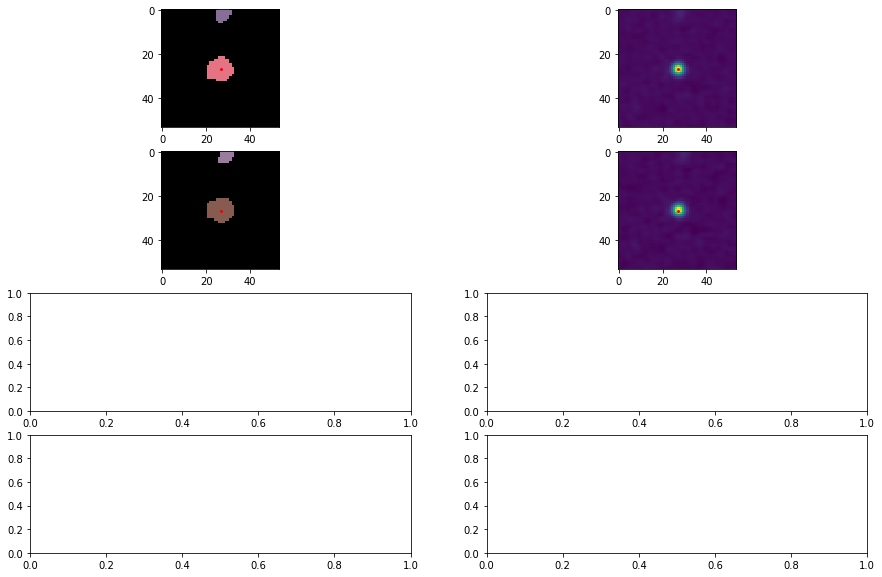

In [34]:
for group in sorted(groups, reverse=True, key=lambda g: len(g[1])):
# random.shuffle(groups)
# for group in groups:
    combs = tuple(flatten(group))
    it = iter(combs)
    combs = tuple(zip(*[it]*2))
    getImgs(
        catalogue, combs
    )
    